In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
customer_df = pd.read_csv('data/Mall_Customers.csv')

# Mall Customer Segmentation

Perform EDA and find the hidden customer spending patterns in the dataset.

# Dataset Overview

In [4]:
customer_df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# EDA

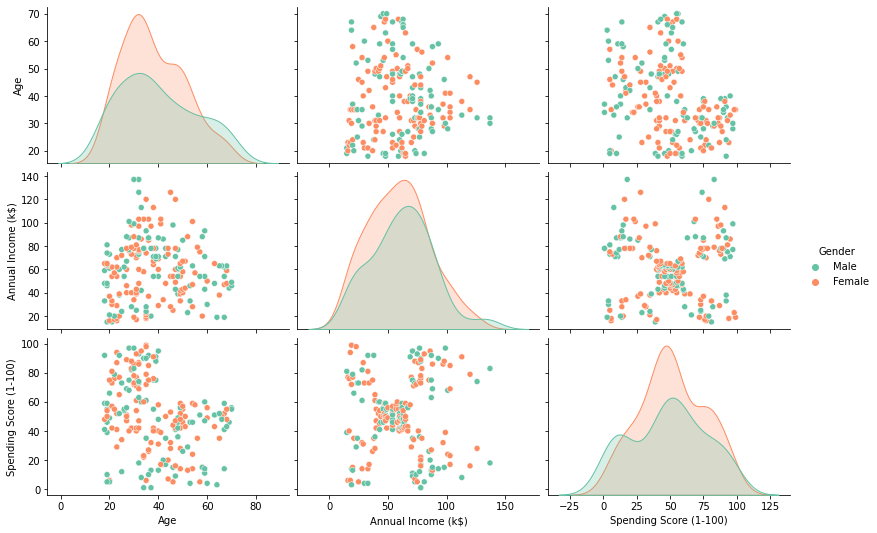

In [25]:
sns.pairplot(customer_df.drop('CustomerID', axis=1), hue='Gender', palette='Set2', aspect=1.5);

Insights:
- Annual Income and Spending Score plot looks unusual. It's formed by 5 dense regions

## Customer Profile

### Gender

In [5]:
fig = px.pie(
    data_frame=customer_df, 
    names='Gender', 
    title='Customer Genders', 
    hole=0.1, 
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig.show()

Insights:
- **female customers** are on 6% more then males

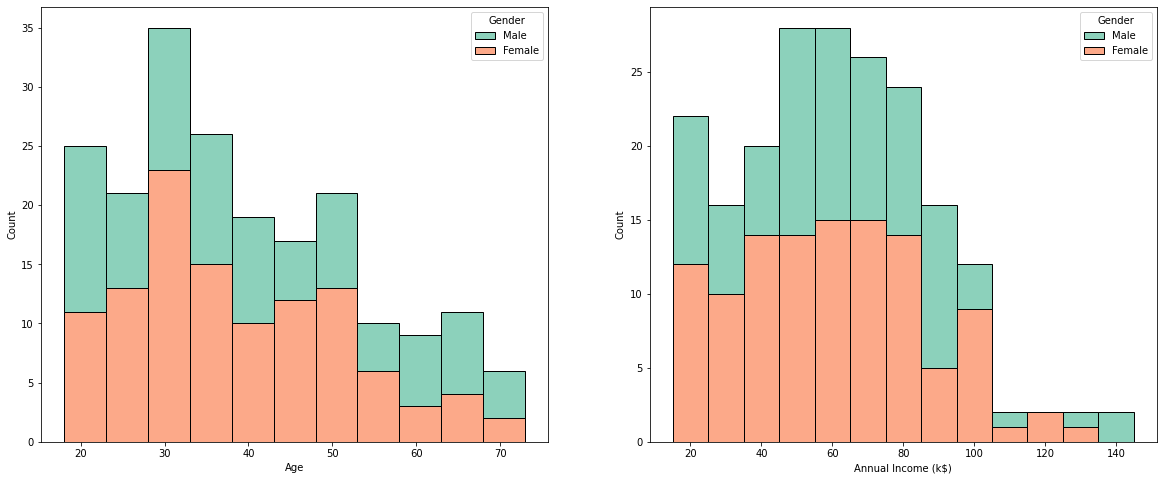

In [30]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 8))

sns.histplot(data=customer_df, x='Age', hue='Gender', binwidth=5, multiple='stack', palette='Set2', ax=ax0)
sns.histplot(data=customer_df, x='Annual Income (k$)', hue='Gender', binwidth=10, multiple='stack', palette='Set2', ax=ax1);

Insights:
- 20, 30, 35, 50 are the most common ages among customers
- the biggest cusomer age group is 30 year-old customers (mostly women)
- most of customers earn between \$50k and \$80k annually
- big part of customers earn only $20k

In [6]:
customer_df['AgeGroup'] = pd.cut(customer_df['Age'], bins=5)
customer_df['IncomeGroup'] = pd.cut(customer_df['Annual Income (k$)'], bins=10)

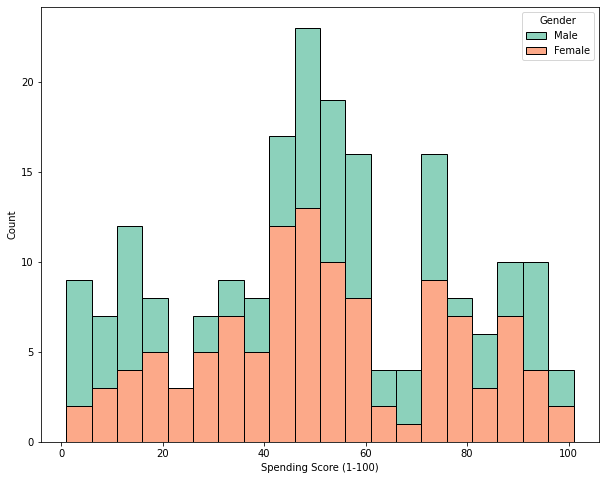

In [31]:
plt.figure(figsize=(10, 8))
sns.histplot(data=customer_df, x='Spending Score (1-100)', hue='Gender', binwidth=5, multiple='stack', palette='Set2');

Insights:
- Spending scores have a few modes: between 0 and 20 (men domintate), between 25 and 40 (women domintate), between 45 and 60 (women domintate), between 65 and 70 (men dominates) and between 70 and 100 (women dominates) 

In [10]:
def get_spending_group(spending_score):
    if spending_score <= 35:
        return 'low'
    if spending_score > 35 and spending_score <= 65:
        return 'medium'
    if spending_score > 65:
        return 'high'

customer_df['SpendingGroup'] = customer_df['Spending Score (1-100)'].apply(get_spending_group)

## Spending Score

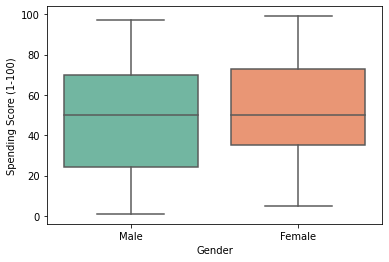

In [15]:
sns.boxplot(data=customer_df, x='Gender', y='Spending Score (1-100)', palette='Set2');

Insights:
- Women tend to spend more as we see from the bottom bar bound
- On average, women just spend slightly more then men

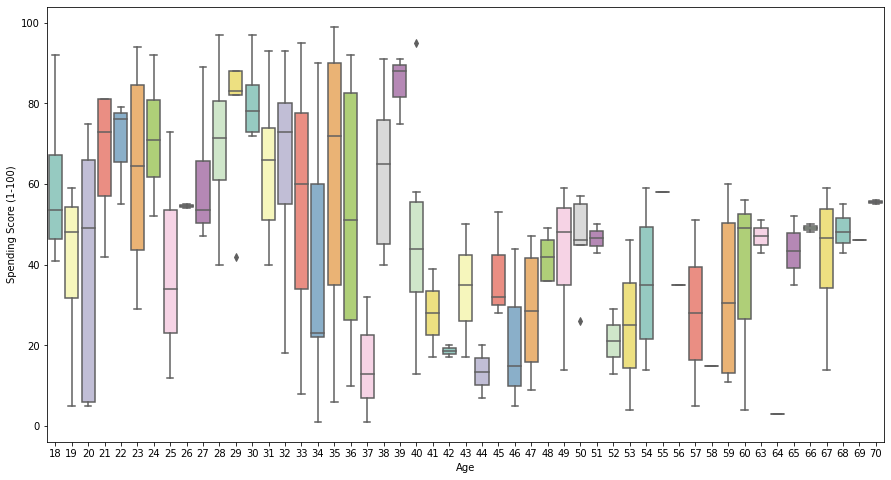

In [16]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=customer_df, x='Age', y='Spending Score (1-100)', palette='Set3');

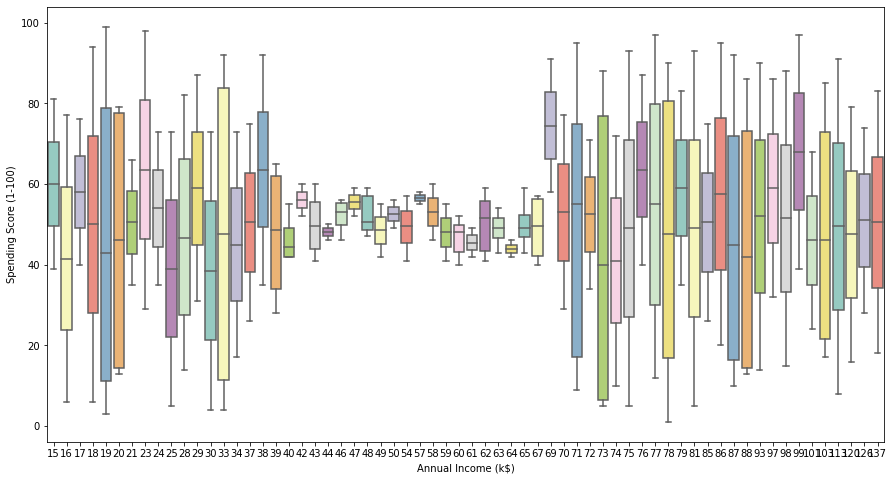

In [17]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=customer_df, x='Annual Income (k$)', y='Spending Score (1-100)', palette='Set3');

<AxesSubplot:xlabel='SpendingGroup', ylabel='Age'>

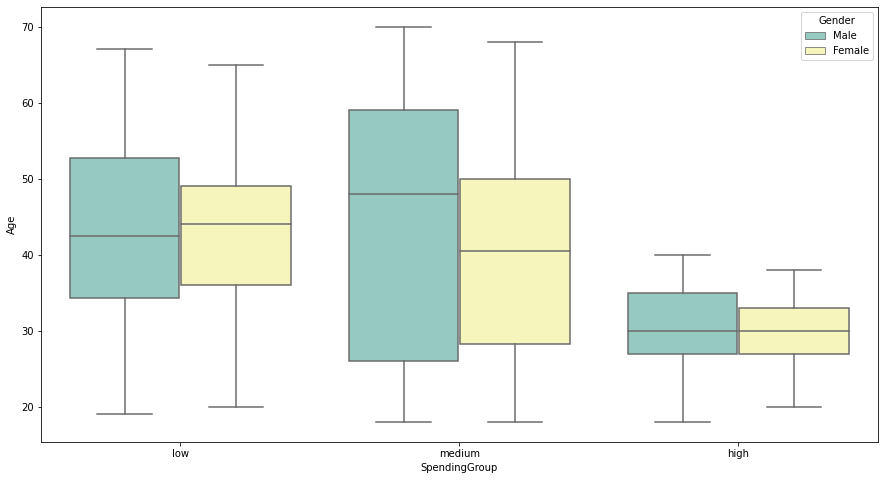

In [15]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=customer_df, x='SpendingGroup', y='Age', hue='Gender', order=['low', 'medium', 'high'], palette='Set3')

<AxesSubplot:xlabel='SpendingGroup', ylabel='Annual Income (k$)'>

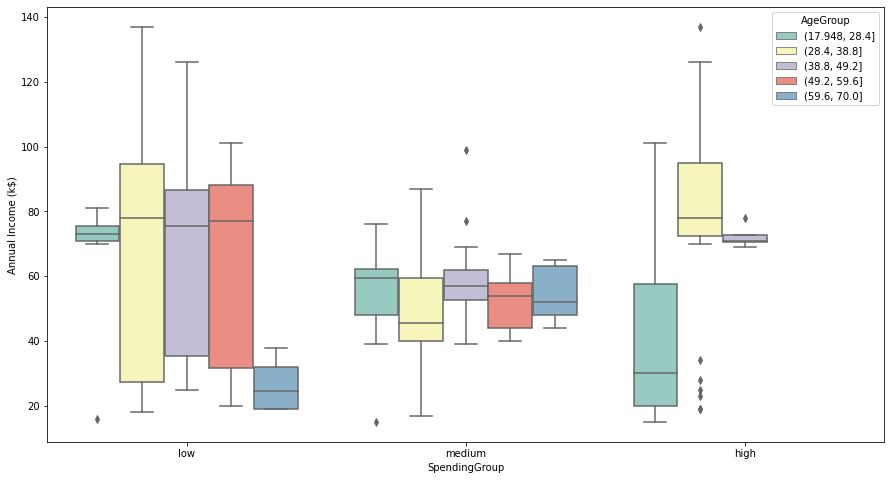

In [17]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=customer_df, x='SpendingGroup', y='Annual Income (k$)', hue='AgeGroup', order=['low', 'medium', 'high'], palette='Set3')

# Clustering

# Summary